# Adult Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.utils import resample

In [2]:
plt.rcParams['figure.figsize'] = [4, 3]

In [3]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df = pd.read_excel('data/existing-customers.xlsx')

In [4]:
df.shape

(32561, 15)

In [5]:
df.head()

,RowID,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,Row0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Row1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Row2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Row3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Row4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   RowID           32561 non-null  object
 1   age             32561 non-null  int64 
 2   workclass       30725 non-null  object
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  class           32561 non-null  object
dtypes: int64(5), object(10)
memory usage: 3.7+ MB


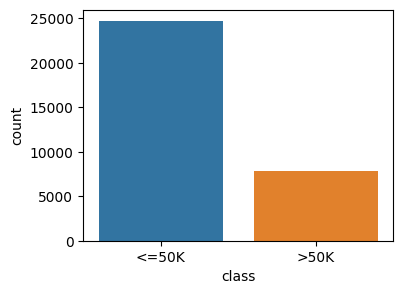

In [7]:
sns.countplot(df, x='class');

In [41]:
df['class'].value_counts()[0] / df['class'].value_counts()[1]

3.152659099604642

### Convert Target Attribute

### Random Undersampling

### Handle Redundant Attributes

- `RowID` does not provide any information
- `education` is equivalent to `education-num`

In [8]:
df2 = df.copy()

df2['class'] = df2['class'].replace({'<=50K': 0, '>50K': 1})

df2.drop(['RowID'], axis=1, inplace=True)
df2.drop(['education'], axis=1, inplace=True)

df2_majority = df2[df2['class'] == 0]
df2_minority = df2[df2['class'] == 1]

# df2_majority_downsampled = resample(df2_majority, 
#                                     replace=False,
#                                     n_samples=len(df2_minority),
#                                     random_state=2)

# df2 = pd.concat([df2_majority_downsampled, df2_minority])

df2_minority_upsampled = resample(df2_minority, 
                                  replace=True,
                                  n_samples=len(df2_majority),
                                  random_state=2)

df2 = pd.concat([df2_majority, df2_minority_upsampled])

df2 = df2.reset_index(drop=True)

df2.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [9]:
df2.shape

(49440, 13)

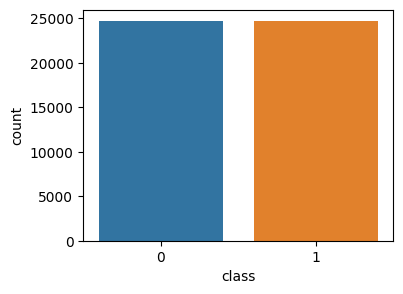

In [10]:
sns.countplot(df2, x='class');

### Handle Missing Values

- `workclass` - impute with most frequent value
- `native-country` - impute with most frequent value
- `occupation` - fill based on frequency to avoid bias

In [11]:
df2.isnull().sum()

age                  0
workclass         2215
education-num        0
marital-status       0
occupation        2222
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     894
class                0
dtype: int64

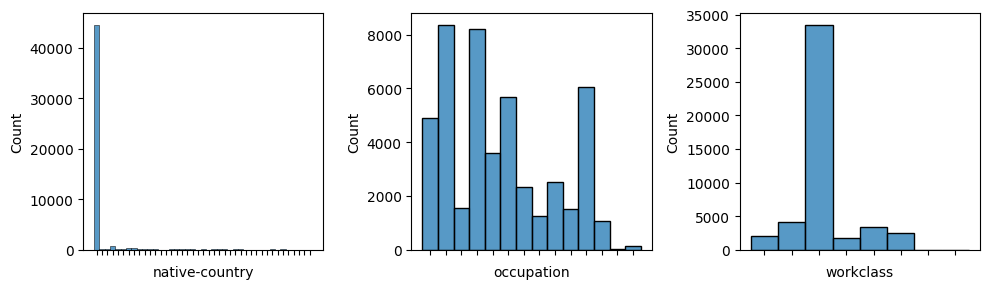

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[2].set_xticklabels([])
sns.histplot(df2, ax=axes[0], x="native-country")
sns.histplot(df2, ax=axes[1], x="occupation")
sns.histplot(df2, ax=axes[2], x="workclass")
plt.tight_layout()

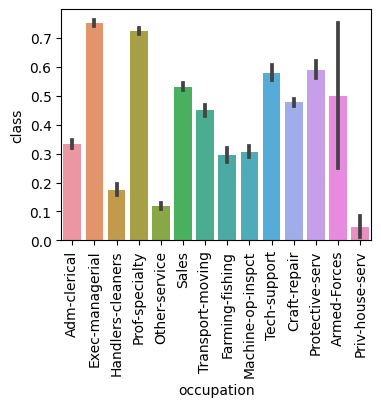

In [13]:
plt.xticks(rotation=90)
sns.barplot(x='occupation', y='class', data=df2);

In [14]:
df3 = df2.copy()

simple_imputer = SimpleImputer(strategy='most_frequent')

df3['workclass'] = simple_imputer.fit_transform(df3[['workclass']])
df3['native-country'] = simple_imputer.fit_transform(df3[['native-country']])

np.random.seed(42)

freqs = df3['occupation'].value_counts(normalize=True)
missing = df3['occupation'].isnull()
n_missing = missing.sum()
fill_values = np.random.choice(freqs.index, size=n_missing, p=freqs.values)
df3.loc[missing, 'occupation'] = fill_values

df3.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [15]:
df3.isnull().sum()

age               0
workclass         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
class             0
dtype: int64

### Handle Outliers

- Transform the data to reduce the impact

In [44]:
gain = ((df['capital-gain'] == 0).sum() / len(df)) * 100
loss = ((df['capital-loss'] == 0).sum() / len(df)) * 100

print(f"capital-gain {gain:.2f}%")
print(f"capital-loss {loss:.2f}%")

capital-gain 91.67%
capital-loss 95.33%


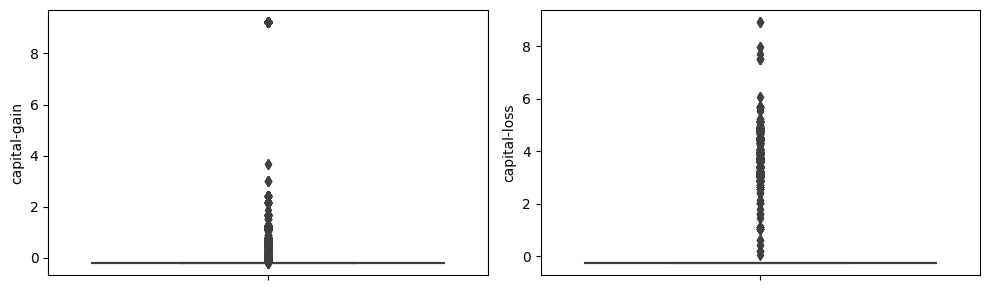

In [54]:
fig, axes = plt.subplots(ncols=2, figsize=(10,3))
sns.boxplot(df3, ax=axes[0], y='capital-gain')
sns.boxplot(df3, ax=axes[1], y='capital-loss')
plt.tight_layout()

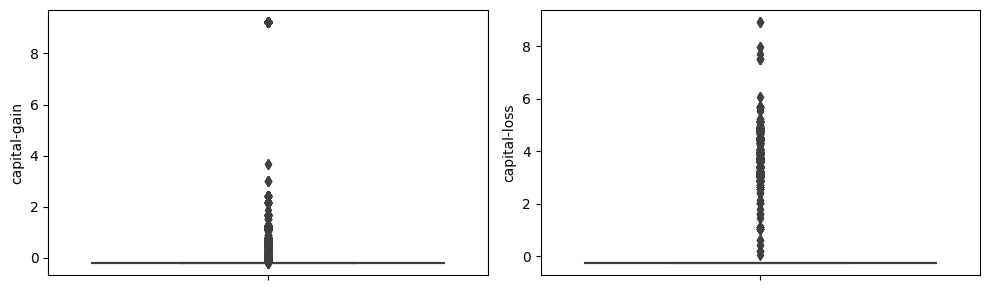

In [55]:
# df3['capital-gain'] = np.log(df3['capital-gain'] + 1)
# df3['capital-loss'] = np.log(df3['capital-loss'] + 1)

scaler = StandardScaler()
df3[['capital-gain', 'capital-loss']] = scaler.fit_transform(df3[['capital-gain', 'capital-loss']])

fig, axes = plt.subplots(ncols=2, figsize=(10,3))
sns.boxplot(df3, ax=axes[0], y='capital-gain')
sns.boxplot(df3, ax=axes[1], y='capital-loss')
plt.tight_layout()

### Converting Features

- Handle attribute cardinality

In [18]:
categorical_cols = [
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country'
]

for var in categorical_cols:
    print(var, ':', len(df3[var].unique()), 'categories')

workclass : 8 categories
marital-status : 7 categories
occupation : 14 categories
relationship : 6 categories
race : 5 categories
sex : 2 categories
native-country : 41 categories


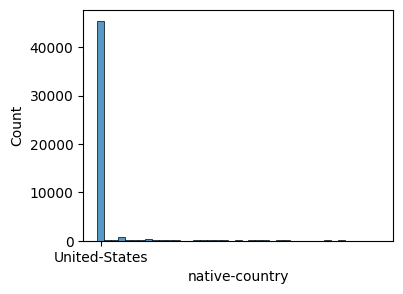

In [50]:
sns.histplot(df3, x="native-country")
value_counts = df3['native-country'].value_counts()
highest_label = value_counts.index[0]
plt.xticks([value_counts.index[0]], labels=[highest_label]);

In [19]:
max_categorical_cols = [
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex'
]

lim_categorical_cols = [
    'native-country'
]

df4 = df3.copy()

encoder = OneHotEncoder(sparse_output=False)
encoded_cols = encoder.fit_transform(df4[max_categorical_cols])
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(max_categorical_cols))

lim_encoder = OneHotEncoder(sparse_output=False, max_categories=3)
lim_encoded_cols = lim_encoder.fit_transform(df4[lim_categorical_cols])
lim_encoded_df = pd.DataFrame(lim_encoded_cols, columns=lim_encoder.get_feature_names_out(lim_categorical_cols))

df4 = df4.drop(max_categorical_cols, axis=1)
df4 = df4.drop(lim_categorical_cols, axis=1)

df4 = pd.concat([df4, encoded_df, lim_encoded_df], axis=1)

df4.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,class,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native-country_Mexico,native-country_United-States,native-country_infrequent_sklearn
0,39,13,0.003513,-0.255798,40,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,50,13,-0.201455,-0.255798,13,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,38,9,-0.201455,-0.255798,40,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,53,7,-0.201455,-0.255798,40,0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,28,13,-0.201455,-0.255798,40,0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [20]:
df4.shape

(49440, 51)

### Machine Learning

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

In [22]:
X = df4.drop(['class'], axis=1)
y = df4['class']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [23]:
params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]}

decision_tree = DecisionTreeClassifier()

# Use grid search to find the best value for max_depth
grid_search = GridSearchCV(estimator=decision_tree, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)

# Get the best value for max_depth and use it to create the final model
best_max_depth = grid_search.best_params_['max_depth']
decision_tree = DecisionTreeClassifier(max_depth=best_max_depth)
decision_tree.fit(X_train, y_train)

print('Best max depth: {}'.format(best_max_depth))

Best max depth: 35


In [24]:
decision_tree = DecisionTreeClassifier(max_depth=best_max_depth, random_state=42)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

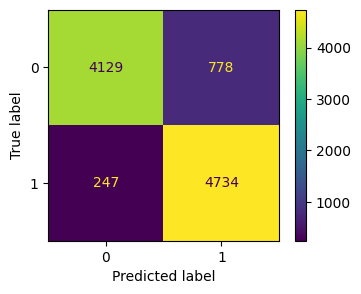

In [25]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [26]:
def profit(cm):
    # Incorrect prediction
    x = cm[0][1] * (-10 + 5/100 * (-310))
    # Correct prediction
    x += cm[1][1] * (-10 + 10/100 * (980))
    
    return x

def bad_profit(cm):
    total = cm[0][0] + cm[1][0]
    # Incorrect prediction
    x = (cm[0][0]/total) * (-10 + 5/100 * (-310))
    # Correct prediction
    x += (cm[1][0]/total) * (-10 + 10/100 * (980))
    
    return x

In [27]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2%}".format(accuracy))
print("Total profit: {:.2f}".format(profit(cm)))
print("Per entry profit: {:.2f}".format(profit(cm) / len(X_test)))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 score: {:.2f}".format(f1))

Accuracy: 89.63%
Total profit: 396753.00
Per entry profit: 40.12
Precision: 0.86
Recall: 0.95
F1 score: 0.90


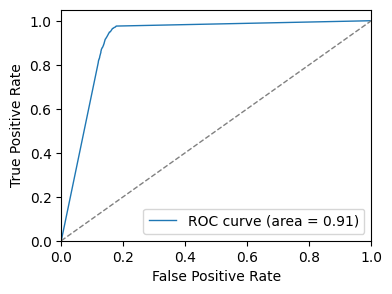

In [28]:
y_proba = decision_tree.predict_proba(X_test)[:, 1]

# Calculate the FPR, TPR, and threshold values for different probability thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1)  # plot the random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [29]:
def gain_for_threshold(threshold):
    # Use the trained classifier to predict the probabilities of the positive class for new instances
    y_proba_new = decision_tree.predict_proba(X_test)[:, 1]
    # Threshold the predicted probabilities using the selected threshold to obtain the predicted class labels
    y_pred_new = (y_proba_new >= threshold).astype(int)
    # Compute the confusion matrix for the predicted labels
    cm = confusion_matrix(y_test, y_pred_new)
    
    gain = profit(cm) / len(X_test)
    return gain

Maximum gain: 41.00879854368932
Threshold: 0.01


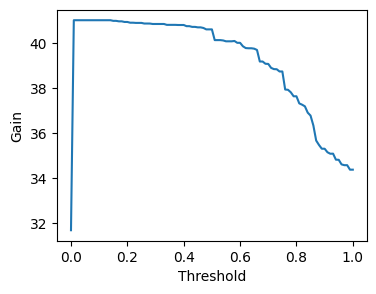

In [30]:
thresholds = np.linspace(0, 1, num=101)

# compute gains for each threshold
gains = np.array([gain_for_threshold(threshold) for threshold in thresholds])

# find the index of the maximum gain
idx_max_gain = np.argmax(gains)
max_gain = gains[idx_max_gain]
max_gain_threshold = thresholds[idx_max_gain]

print("Maximum gain:", max_gain)
print("Threshold:", max_gain_threshold)

plt.plot(thresholds, gains)
plt.xlabel('Threshold')
plt.ylabel('Gain')
plt.show()

In [31]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train) 
y_pred = gaussian.predict(X_test)

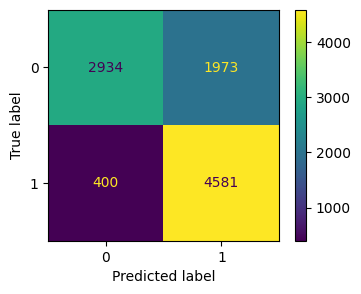

In [32]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [33]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2%}".format(accuracy))
print("Total profit: {:.2f}".format(profit(cm)))
print("Per entry profit: {:.2f}".format(profit(cm) / len(X_test)))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 score: {:.2f}".format(f1))

Accuracy: 76.00%
Total profit: 352816.50
Per entry profit: 35.68
Precision: 0.70
Recall: 0.92
F1 score: 0.79


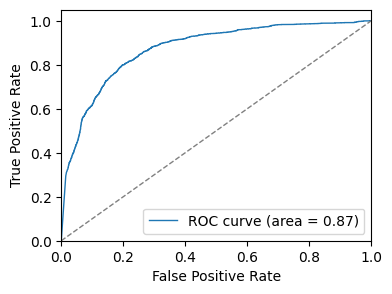

In [34]:
y_proba = gaussian.predict_proba(X_test)[:, 1]

# Calculate the FPR, TPR, and threshold values for different probability thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1)  # plot the random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [35]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train) 
y_pred = logreg.predict(X_test)

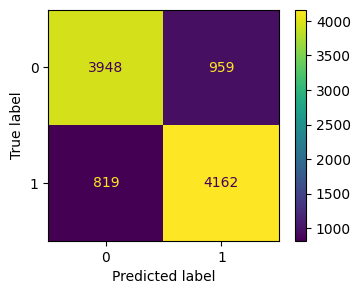

In [36]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [37]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2%}".format(accuracy))
print("Total profit: {:.2f}".format(profit(cm)))
print("Per entry profit: {:.2f}".format(profit(cm) / len(X_test)))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 score: {:.2f}".format(f1))

Accuracy: 82.02%
Total profit: 341801.50
Per entry profit: 34.57
Precision: 0.81
Recall: 0.84
F1 score: 0.82


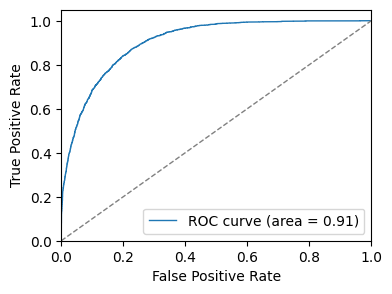

In [38]:
y_proba = logreg.predict_proba(X_test)[:, 1]

# Calculate the FPR, TPR, and threshold values for different probability thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1)  # plot the random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()